In [1]:
"""
Debug lenmap2gclm
"""
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cunusht
from cunusht.geometry import get_geom
from cunusht.helper_CPU import dlm2A
import cupy as cp
import sys
from time import process_time
from lenspyx.lensing import get_geom as get_lenspyxgeom
from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from delensalot.utility.plot_helper import bandpass_alms


magnific = None
runinfos = [
    # ("CPU", "lenspyx", 'ducc'),
    ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]
epsilon = 1e-10
lmaxs = [511]
nthreads = 20
phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
wCPU, wGPU = None, None
for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
    geominfo = ('gl',{'lmax':lmax})
    lenjob_geominfo = ('gl',{'lmax':phi_lmax})
    lldlm = np.arange(0,phi_lmax+1)
    synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=lenjob_geominfo, epsilon=1e-10)
    philm = synunl.get_sim_phi(0, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
    toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
    for runinfo in runinfos:
        backend = runinfo[0]
        defres.update({backend: {}}) if backend not in defres.keys() else None
        solver = runinfo[1]

        if backend == 'CPU':
            magnific = dlm2A(toydlm, phi_lmax, phi_lmax, get_lenspyxgeom(lenjob_geominfo), nthreads=10)
            if solver == 'lenspyx':
                kwargs = {
                    'geominfo_deflection': lenjob_geominfo,
                    'dglm': toydlm,
                    'mmax_dlm': lmax,
                    'nthreads': nthreads,
                    'verbose': 1,
                    'epsilon': epsilon,
                    'single_prec': True,
                }   
                t = cunusht.get_transformer(backend, solver)
                t = t(**kwargs)
                
                nalm = toyunllm.shape[-1]
                gclm = np.array(np.zeros(shape=(1, nalm)), dtype=np.complex128) if not kwargs["single_prec"] else np.array(np.zeros(shape=(nalm)), dtype=np.complex64)
                _ = Tsky2.copy()
                defres[backend][solver] = t.lenmap2gclm(
                    np.atleast_2d(_), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, gclm_out=gclm, nthreads=nthreads, execmode='debug', epsilon=epsilon, ptg=None)
            else:
                kwargs = {
                    'geominfo_deflection': lenjob_geominfo,
                    'nuFFTtype': None,
                }
                t = cunusht.get_transformer(backend, solver)
                t = t(**kwargs)
                gclm = np.array(np.zeros(shape=(1, t.deflectionlib.geom.nalm(lmax, lmax))), dtype=np.complex128) if epsilon<=1e-6 else np.array(np.zeros(shape=(t.deflectionlib.geom.nalm(lmax, lmax))), dtype=np.complex64)
                _ = Tsky2.copy()
                defres[backend][solver] = t.lenmap2gclm(
                        np.atleast_2d(_), dlm=toydlm, gclm_out=gclm, lmax=lmax, mmax=lmax, spin=0, nthreads=nthreads, epsilon=epsilon, execmode='debug')
        elif backend == 'GPU':
            kwargs = {
                'geominfo_deflection': lenjob_geominfo,
                'epsilon': epsilon,
                'nuFFTtype': 1,
            }
            t = cunusht.get_transformer(backend, solver)
            t = t(**kwargs)
            lenmap = np.atleast_2d(Tsky2)
            lenmap = cp.array(lenmap, dtype=np.complex128) if kwargs['epsilon']<=1e-6 else cp.array(lenmap.astype(np.complex64))
            ll = np.arange(0,lmax+1,1)
            dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
            dlm_scaled = cp.array(np.atleast_2d(dlm_scaled), dtype=np.complex128) if kwargs['epsilon']<=1e-6 else cp.array(np.atleast_2d(dlm_scaled).astype(np.complex64))
            gclm = cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex128) if kwargs['epsilon']<=1e-6 else cp.array(np.zeros(shape=(1,t.geom.nalm(lmax, lmax))), dtype=np.complex64)
            defres[backend][solver] = t.lenmap2gclm(lenmap, dlm_scaled=dlm_scaled, lmax=lmax, mmax=lmax, gclm=gclm, epsilon=epsilon, execmode='debug')

mpisupport: False, pmisupport: False
disabling mpi
could not load wigners.so fortran shared object
try f2py -c -m wigners wigners.f90 from the command line in wigners directory ?
Using lenspyx alm2map
INFO:: 06-01 09:14:13:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 06-01 09:14:13:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 06-01 09:14:13:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 06-01 09:14:13:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 06-01 09:14:13:: numexpr.utils._init_num_threads - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:: 06-01 09:14:13:: numexpr.utils._init_num_threads - NumExpr defaulting to 8 threads.
Running in debug execution mode
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (131328,)
  Output shape: [(524288,), (5242

setup_spreader warning: at upsampfac=1.25, tol=1e-10 would need kernel width ns=17; clipping to max 16.


Running in debug execution mode
- - - - - - - - - - - - - - - Timing spin-1 synth: 0.003 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing pointing: 0.005 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing dlm2pointing: 0.010 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing dlm2pointing: 0.020 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing nuFFT2d1: 0.006 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing iC2C: 0.000 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing adjointdoubling: 0.002 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing adjointsynthesis: 0.001 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing adjointsynthesisgeneral: 0.038 seconds- - - - - - - - - - - - - - - 

::debug:: Returned component results
- - - - - - - - - - - - - - - Timing lenmap2gclm: 0.055 seconds- 

/tmp/ipykernel_647938/3692966371.py:93: RuntimeWarning: divide by zero encountered in divide
  dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


(1, 131328) (131328,)


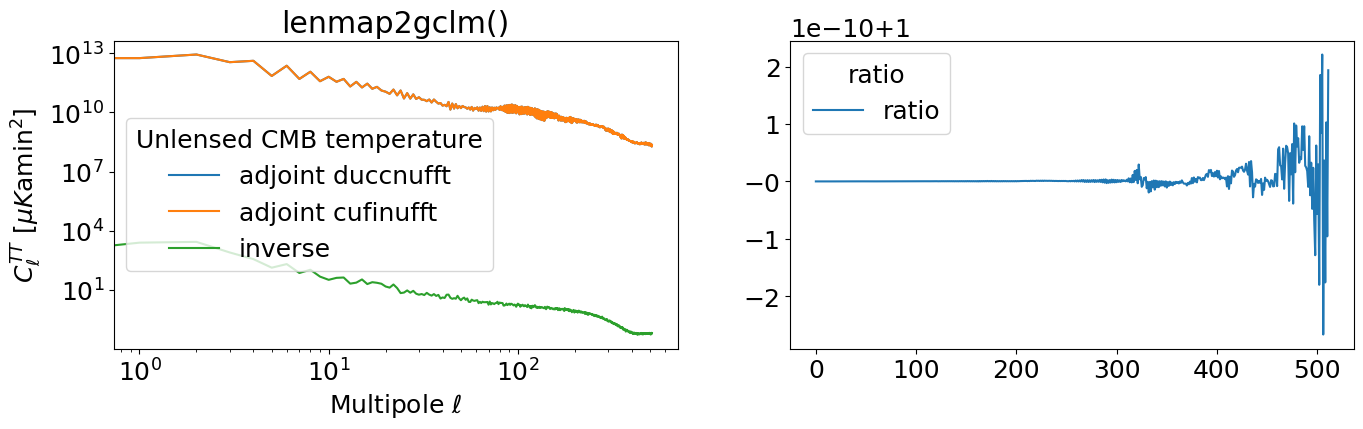

In [2]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(1,2, figsize=(16,4))
print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)

resCPU = hp.alm2cl(defres['CPU'][solverCPU][key][0])
resGPU = hp.alm2cl(defres['GPU'][solverGPU][key])

ax[0].plot(resCPU, label="adjoint " + solverCPU)
ax[0].plot(resGPU, label="adjoint " + solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='inverse')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(resGPU/resCPU, label='ratio')
ax[1].legend(title='ratio')

# CPU vs GPU

## Only for lenpsyx

In [2]:
solverCPU, solverGPU = 'lenspyx', 'cufinufft'
defres['CPU'][solverCPU].keys(), defres['GPU'][solverGPU].keys()

(dict_keys(['dlm2pointing', 'adjointsynthesisgeneral']),
 dict_keys(['dlm2pointing', 'nuFFT2d1', 'iC2C', 'adjointdoubling', 'adjointsynthesis']))

[1065546.65609643     +0.j           82040.26980908     +0.j
   49116.31790073     +0.j         ...   -3190.52138024-102191.71801407j
  -32678.39645219 -11945.21318412j   23628.99526892 +55300.28807663j]


(0.999, 1.001)

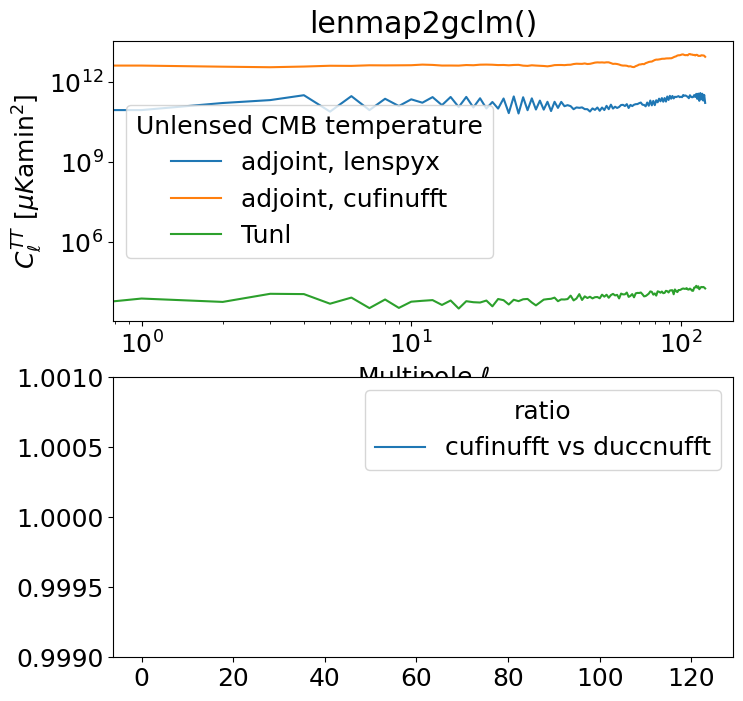

In [3]:
key = 'adjointsynthesis'
keyCPU = 'adjointsynthesisgeneral'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'
fig, ax = plt.subplots(2,1, figsize=(8,8))
ll = np.arange(1,phi_lmax+2)*np.arange(2, phi_lmax+3)
resCPU = defres['CPU'][solverCPU][keyCPU][0]
resGPU = defres['GPU'][solverGPU][key]


ax[0].plot(ll*hp.alm2cl(resCPU.astype(complex)), label="adjoint, " + solverCPU)
ax[0].plot(ll*hp.alm2cl(resGPU.astype(complex)), label="adjoint, " + solverGPU)
ax[0].plot(ll*hp.alm2cl(toyunllm), label='Tunl')

ax[0].legend(title='Unlensed CMB temperature')

# ax[0].set_ylim(1e3, 1e5)
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(resCPU)/hp.alm2cl(resGPU), label='cufinufft vs duccnufft')
ax[1].legend(title='ratio')
ax[0].loglog()
ax[1].set_ylim(0.999,1.001)


In [2]:
keyGPU = 'dlm2pointing'
keyCPU = 'dlm2pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

resCPU = defres['CPU'][solverCPU][keyCPU].T
resGPU = defres['GPU'][solverGPU][keyGPU].T

fig, ax = plt.subplots(2,3, figsize=(14,6))

ax[0,0].imshow(resCPU[0,:].reshape(lmax+1,-1))
ax[0,0].set_title("CPU")
ax[0,1].imshow(resGPU[:,0].reshape(lmax+1,-1))
ax[0,1].set_title("GPU")

ax[1,0].imshow(resCPU[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(resGPU[:,1].reshape(lmax+1,-1))

ax[0,2].imshow(resCPU[0,:].reshape(lmax+1,-1) - resGPU[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[1,2].imshow(resCPU[1,:].reshape(lmax+1,-1) - resGPU[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

KeyError: 'lenspyx'

# all others

In [2]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
defres['CPU'][solverCPU].keys(), defres['GPU'][solverGPU].keys()

(dict_keys(['dlm2pointing', 'nuFFT2d1', 'iC2C', 'adjointdoubling', 'adjointsynthesis', 'adjointsynthesisgeneral']),
 dict_keys(['dlm2pointing', 'nuFFT2d1', 'iC2C', 'adjointdoubling', 'adjointsynthesis']))

(2, 524288) (524288, 2)


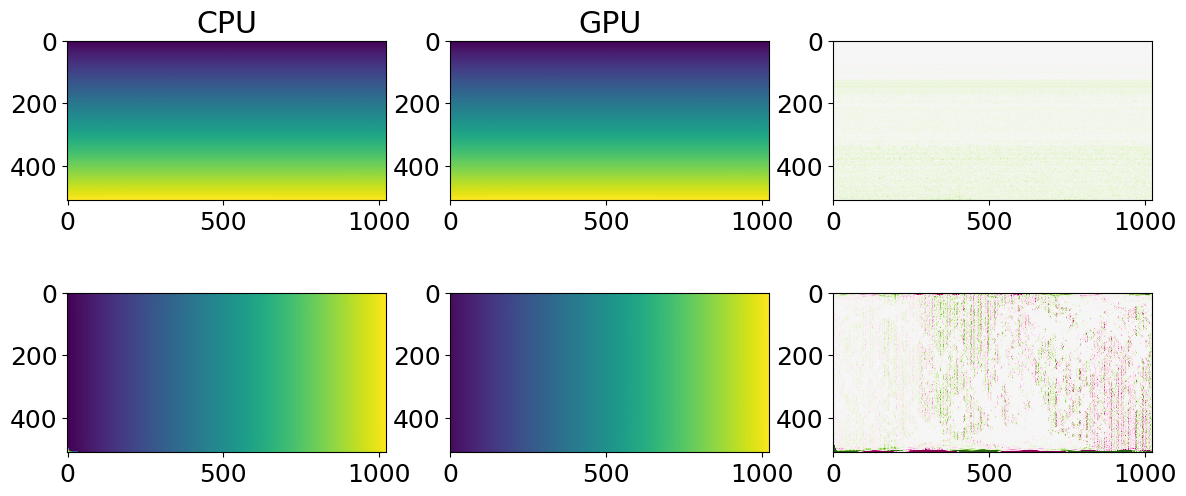

In [7]:
keyGPU = 'dlm2pointing'
keyCPU = 'dlm2pointing'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'


resCPU = defres['CPU'][solverCPU][keyCPU].T
resGPU = defres['GPU'][solverGPU][keyGPU].T
print(resCPU.shape, resGPU.shape)

fig, ax = plt.subplots(2,3, figsize=(14,6))

ax[0,0].imshow(resCPU[0,:].reshape(lmax+1,-1))
ax[0,0].set_title("CPU")
ax[0,1].imshow(resGPU[:,0].reshape(lmax+1,-1))
ax[0,1].set_title("GPU")

ax[1,0].imshow(resCPU[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(resGPU[:,1].reshape(lmax+1,-1))

ax[0,2].imshow(resCPU[0,:].reshape(lmax+1,-1) - resGPU[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[1,2].imshow(resCPU[1,:].reshape(lmax+1,-1) - resGPU[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

## synthesis general

(254, 250) (254, 250)


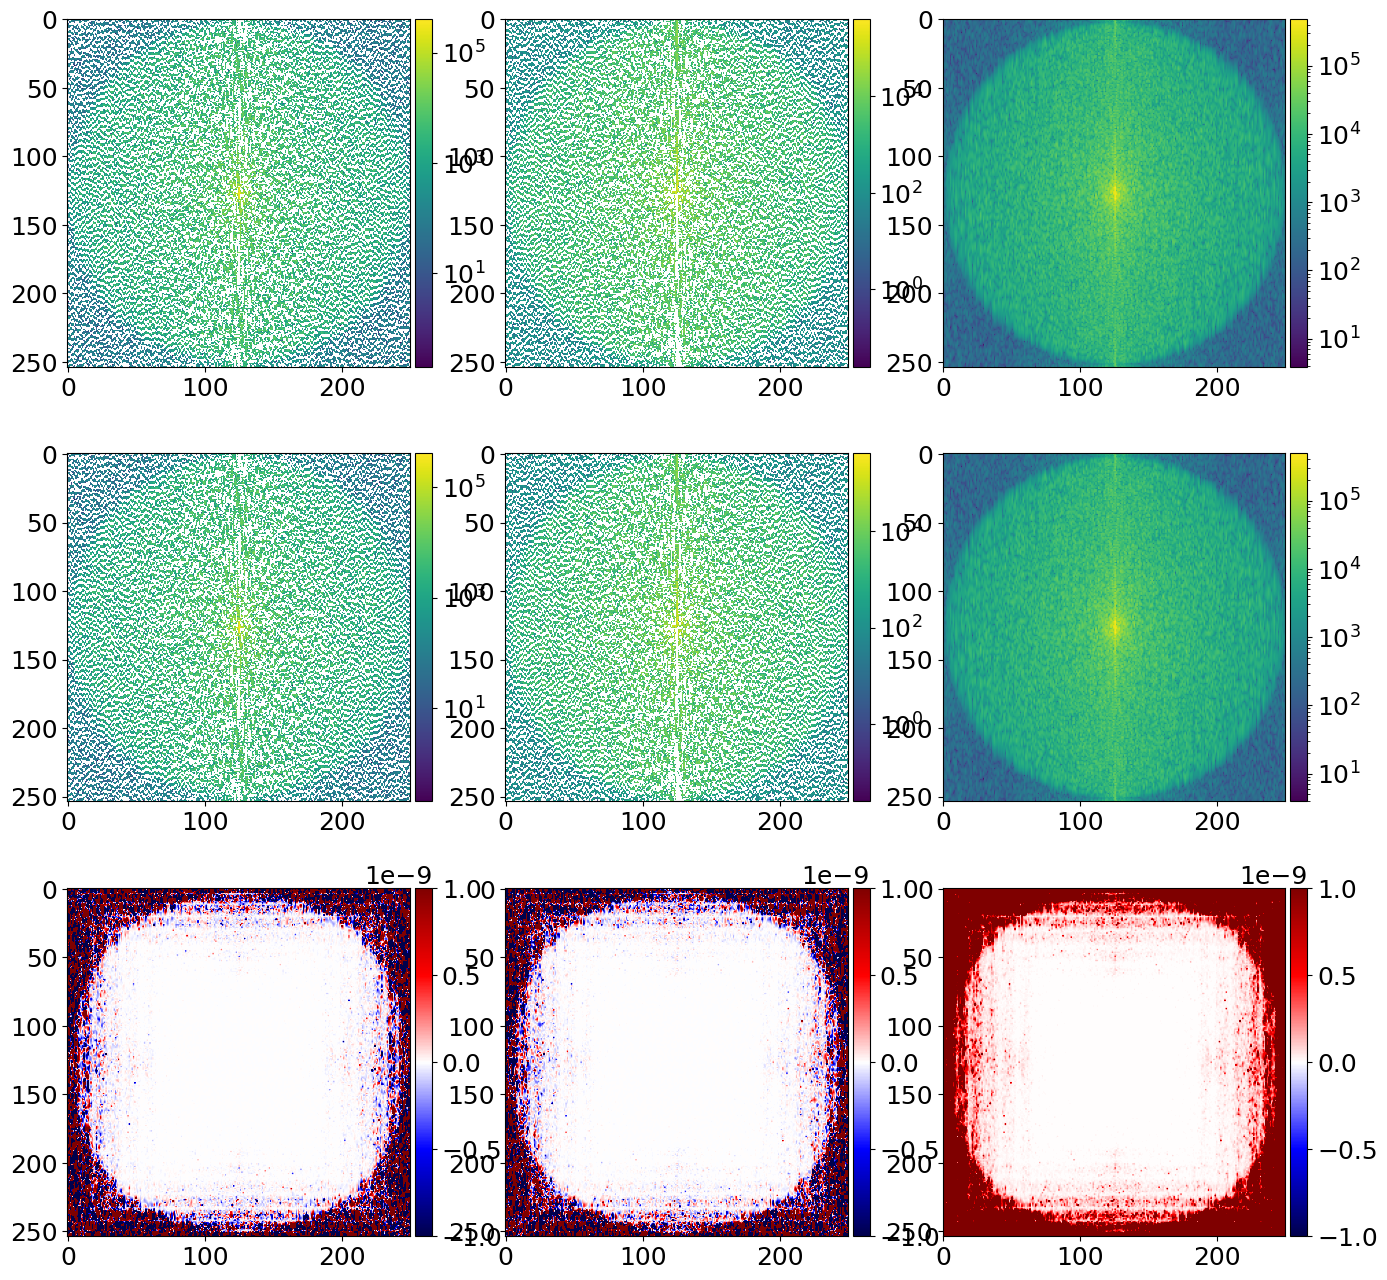

In [5]:
key = 'nuFFT2d1'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'

print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)

fig, ax = plt.subplots(3,3, figsize=(16,16))

resCPU = np.fft.fftshift(defres['CPU'][solverCPU][key],axes=(0,1))
resGPU = defres['GPU'][solverGPU][key]

im = ax[0,0].imshow(np.real(resCPU), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(resCPU), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(resCPU), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(resGPU), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(resGPU), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(resGPU), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -epsilon*1e1, epsilon*1e1
# vmin, vmax = None, None
im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(1054, 1024) (1054, 1024)


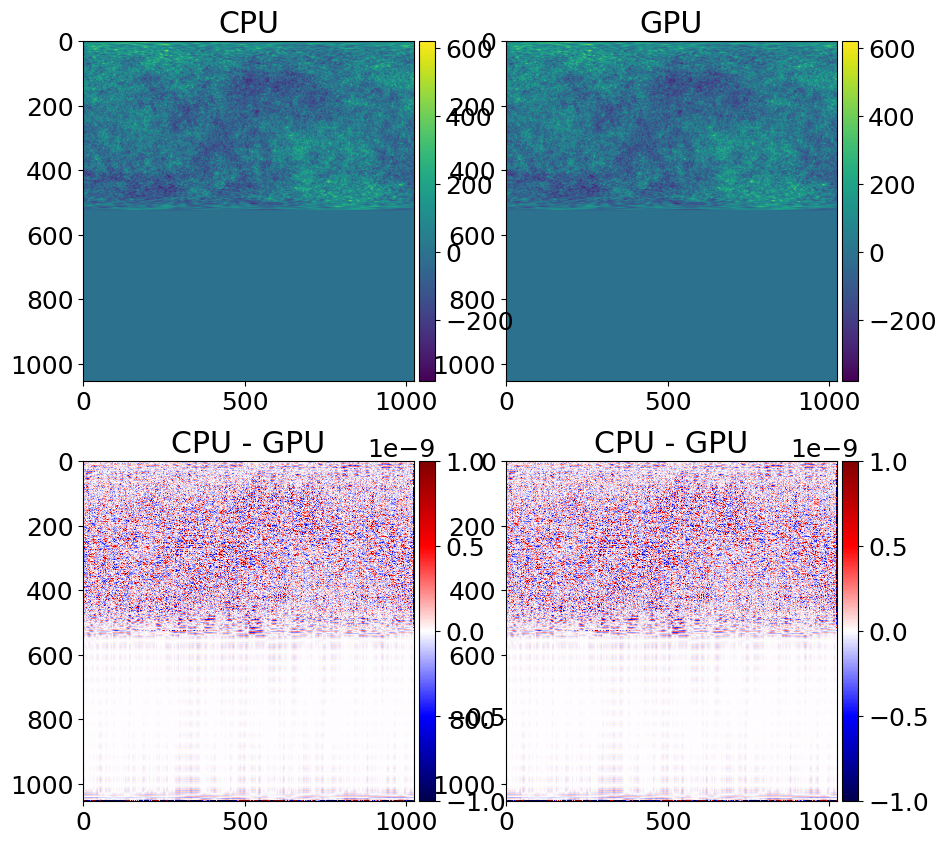

In [6]:
key = 'iC2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'

vmin, vmax = -4e2, 4e2
vmin, vmax = None, None
print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)
Tsky = Tsky2

resCPU = np.real(defres['CPU'][solverCPU][key])#[::2,::2])
resGPU = np.real(defres['GPU'][solverGPU][key])#[::2,::2])
fig, ax = plt.subplots(2,2, figsize=(10,10))

# ax[0,0].imshow(Tsky[:500*(t.nphi_CAR)].reshape(-1,t.nphi_CAR).real, vmin=vmin, vmax=vmax)
# ax[0,0].imshow(Tsky.reshape(2*t.ntheta_CAR-2,t.nphi_CAR), vmin=vmin, vmax=vmax)
# ax[0,0].set_title('Tsky')

im = ax[0,0].imshow(resCPU.reshape((2*t.ntheta_CAR-2),t.nphi_CAR), vmin=vmin, vmax=vmax)
ax[0,0].set_title('CPU')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[0,1].imshow(resGPU.reshape((2*t.ntheta_CAR-2,t.nphi_CAR)).astype(np.double), vmin=vmin, vmax=vmax)
ax[0,1].set_title('GPU')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -epsilon*1e1, epsilon*1e1
im = ax[1,0].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU-resGPU).reshape(-1,t.nphi_CAR), vmin=vmin, vmax=vmax, cmap='seismic')
ax[1,1].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(300.0, 600.0)

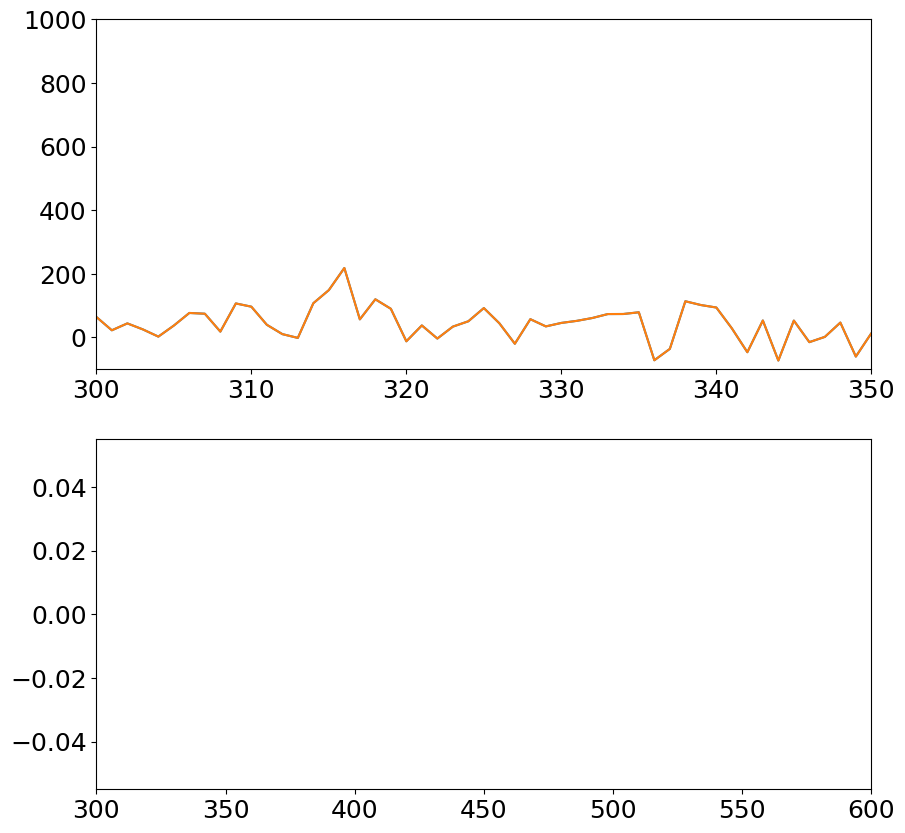

In [8]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(resCPU.real.flatten()[::10])
ax[0].plot(resGPU.real.flatten()[::10])
ax[0].set_xlim(0,2e6)
ax[0].set_xlim(300,350)
ax[0].set_ylim(-1e2,1e3)

ax[1].plot(resCPU.imag.flatten()[::1000])
ax[1].plot(resGPU.imag.flatten()[::1000])
ax[1].set_xlim(0,2e6)
ax[1].set_xlim(300,600)
# ax[1].set_ylim(-1e0,1e0)
# plt.imshow(defres['GPU'][solverGPU][key][0][::2,::2].real)

(528, 1024) (528, 1024)


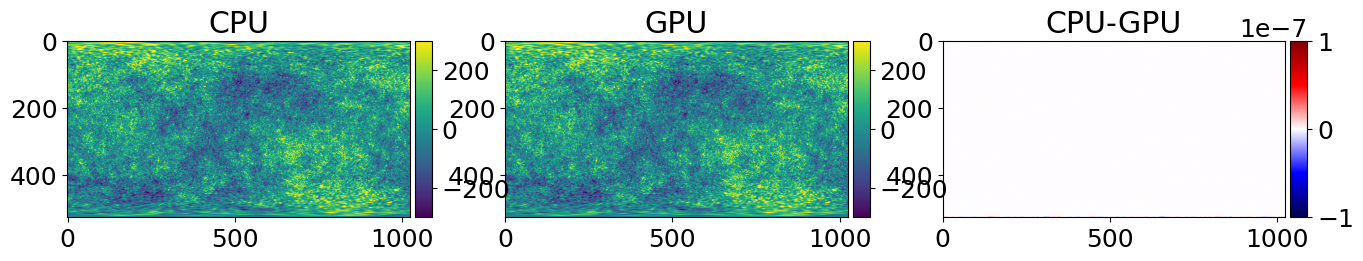

In [3]:
key = 'adjointdoubling'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(1,3, figsize=(16,4))

resCPU = defres['CPU'][solverCPU][key][0].real
resGPU = defres['GPU'][solverGPU][key].reshape(-1,t.constructor.nphi)
print(resCPU.shape, resGPU.shape)

vmin, vmax = -3e2, 3e2
im = ax[0].imshow(resCPU, vmin=vmin, vmax=vmax)
ax[0].set_title('CPU')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1].imshow(resGPU, vmin=vmin, vmax=vmax)
ax[1].set_title('GPU')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax = -epsilon*1e3, epsilon*1e3
im = ax[2].imshow(resCPU-resGPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1, 131328) (1, 131328)


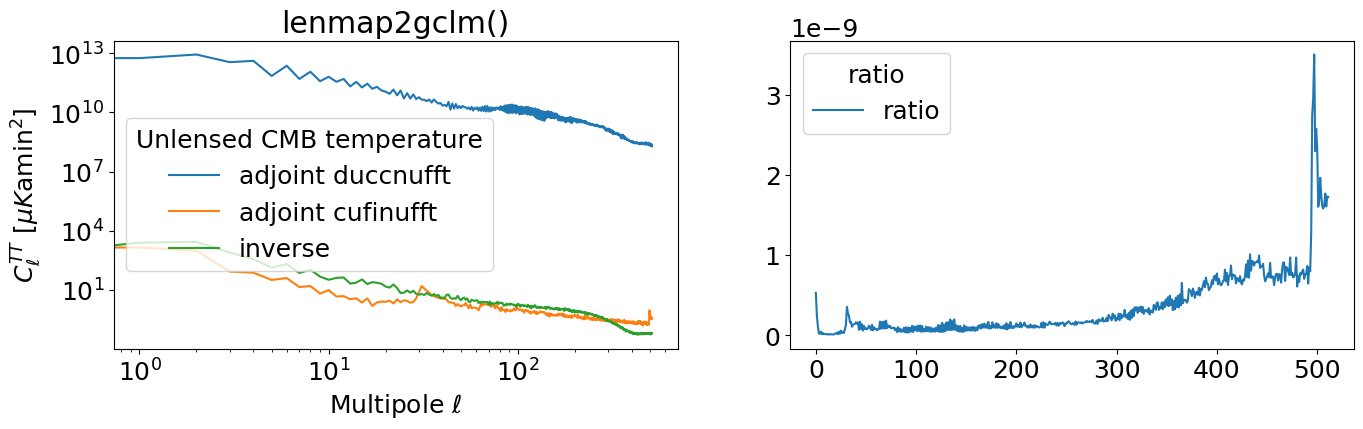

In [2]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
fig, ax = plt.subplots(1,2, figsize=(16,4))
print(defres['CPU'][solverCPU][key].shape, defres['GPU'][solverGPU][key].shape)

resCPU = hp.alm2cl(defres['CPU'][solverCPU][key][0])
resGPU = hp.alm2cl(defres['GPU'][solverGPU][key][0])

ax[0].plot(resCPU, label="adjoint " + solverCPU)
ax[0].plot(resGPU, label="adjoint " + solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='inverse')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

# ax[1].plot(resCPU/hp.alm2cl(toyunllm), label=solverCPU)
# ax[1].plot(resGPU/hp.alm2cl(toyunllm), label=solverGPU)
ax[1].plot(resGPU/resCPU, label='ratio')
# ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(toyunllm), label='Juliens test: adjoint_synth(Tlen)')
ax[1].legend(title='ratio')
# ax[1].set_ylim(0.95,1.01)
# ax[1].loglog()
# ax[1].plot(hp.alm2cl(), label=solverGPU)

# Weights and inverse stuff

In [ ]:
ginfo = ('cc',{'ntheta': lmax+9, 'nphi':2*(lmax+9)})

g = get_geom(ginfo)
gCC_CPU = g.weight
print(wGPU.shape, gCC_CPU.shape)
_ = np.zeros(shape=wGPU.shape)
_[4:-4] = wCPU
# plt.plot(wGPU)
# plt.plot(gCC_CPU)
# plt.plot(_)
plt.plot(gCC_CPU/_)
plt.hlines(1,4,256)
plt.xlim(4, 256)

In [ ]:
from lenspyx.tests.helper import syn_ffi_ducc_29, cls_unl
from lenspyx.utils import timer
from lenspyx.utils_hp import Alm, synalm
import numpy as np
import pylab as pl
import healpy as hp

tim = timer(True)
ffi, _ = syn_ffi_ducc_29(lmax_len=phi_lmax, dlmax=0, dlmax_gl=0, dlm=toydlm, epsilon=epsilon)
Aunl = ffi.dlm2A()

lmax, mmax = phi_lmax, phi_lmax
# tlm_unl = synalm(cls_unl['tt'][:lmax + 1], lmax, mmax).astype(np.complex64)
tmap_len = ffi.gclm2lenmap(toyunllm, mmax, 0, backwards=False)

points1 = tmap_len.copy()
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points1[ofs:ofs + nph] *= w
points1 = points1
points2 = tmap_len * Aunl
# for ofs, w, nph in zip(ffi.geom.ofs, ffi.geom.weight, ffi.geom.nph):
    # points2[ofs:ofs + nph] *= w
points2 = points2

tlm_unl_1 = ffi.lenmap2gclm(points1, 0, lmax, mmax).astype(np.complex128)
tlm_unl_2 = ffi.lenmap2gclm(points2, 0, lmax, mmax).astype(np.complex128)
# tlm_unl_3 = ffi.lenmap2gclm(np.atleast_2d(Tsky2), 0, lmax, mmax).astype(np.complex128)

In [ ]:
key = 'adjointsynthesis'
solverCPU, solverGPU = 'lenspyx', 'duccnufft'
vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0].shape)

# ax[0].plot(hp.alm2cl(defres['CPU'][solverCPU]["adjointsynthesisgeneral"][0][0]), label=solverCPU)
ax[0].plot(hp.alm2cl(defres['CPU'][solverGPU][key][0][0]), label=solverGPU)
ax[0].plot(hp.alm2cl(toyunllm), label='Truth')

# ax[0].plot(hp.alm2cl(tlm_unl_1.astype(complex)), label='adjoint_synth(Tlen)')
# ax[0].plot(hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen*A)')

ax[0].legend(title='Unlensed CMB temperature')
ax[0].loglog()
ax[0].set_title('lenmap2gclm()')

ax[0].set_xlabel(r'Multipole $\ell$')
ax[0].set_ylabel(r'$C_\ell^{TT}\ [\mu K {\rm amin}^2]$')

ax[1].plot(hp.alm2cl(tlm_unl_1.astype(complex))/hp.alm2cl(tlm_unl_2.astype(complex)), label='adjoint_synth(Tlen)')
ax[1].set_ylim(0.99,1.21)

ax[2].plot(Tsky2-tmap_len[0])
ax[2].set_xlim(0,10000)